In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import lstsq
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
def extract_neighborhood(data, i, j):
    """Extracts a 3x3 neighborhood around pixel (i, j)"""
    # Pad data to handle edges
    padded_data = np.pad(data, 2, mode='edge')
    # Make sure to extract so that (i, j) is the center
    return padded_data[i-2:i+3, j-2:j+3].flatten()

def fit_plane(neighborhood):
    """Fits a plane to a 3x3 neighborhood"""
    # Create coordinates for a 3x3 grid centered at (0, 0)
    x, y = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
    x = x.flatten()
    y = y.flatten()
    
    # Formulate the least squares problem Ax = b
    A = np.column_stack([x, y, np.ones(25)])
    b = neighborhood
    
    # Solve the least squares problem
    coeffs, residuals, rank, s = lstsq(A, b, lapack_driver='gelsy')
    return coeffs  # Returns [a, b, c] coefficients of the plane


def process_image(data):
    """Applies plane fitting to each pixel using nested loops"""
    rows, cols = data.shape
    coeffs_matrix = np.zeros((rows, cols, 3))  # To store a, b, c coefficients for each pixel

    for i in range(rows):
        for j in range(cols):
            neighborhood = extract_neighborhood(data, i+2, j+2)  # Account for padding in indices
            coeffs = fit_plane(neighborhood)
            # Store the coefficients at the corresponding pixel position
            coeffs_matrix[i, j] = coeffs

    return coeffs_matrix

### Soft_Homo

In [164]:
out = []

for i in tqdm(range(1,189)):
    df = pd.read_csv('manu/Soft_Homo_Final_42x41/Soft_Homo_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-3,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 188/188 [00:27<00:00,  6.86it/s]


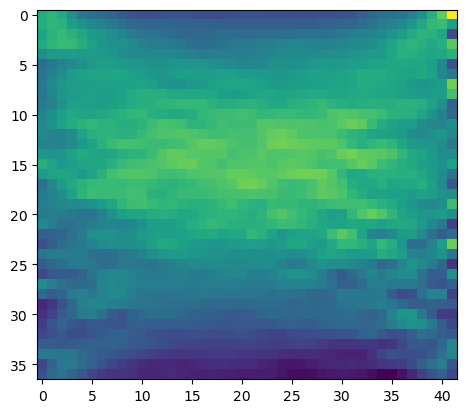

In [165]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [166]:
"""
What is happening here:
1. Load the deformation gradient history for all pixels and average over the pixels
2. Load the force-displacement dataframe from the csv file
3. The deformation gradients and the forces are sampled at different times. Also, the
    force seems to increase very linearly. I make the assumption that they start and 
    end at the same time, and use this information to interpolate the force such that
    it takes the same shape as the deformation gradient history.
    This assumes that both the F and force were sampled in regular intervals.
    This needs to be changed later on because Manu specifically said "the timing is 
    NOT constant or consistent between files (more about this later)" in his email.
"""

force_disp = pd.read_csv('manu/Soft_Homo_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [167]:
with open('manu/soft_homo.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)

### Stiff1_Homo

In [168]:
out = []

for i in tqdm(range(1,189)):
    df = pd.read_csv('manu/Stiff1_Homo_Final_42x41/Stiff1_Homo_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-3,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 188/188 [00:27<00:00,  6.88it/s]


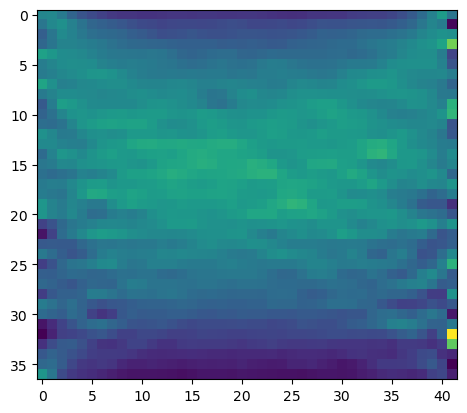

In [169]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [170]:
force_disp = pd.read_csv('manu/Stiff1_Homo_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [171]:
with open('manu/stiff1_homo.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)

### Stiff2_Homo

In [173]:
out = []

for i in tqdm(range(1,188)):
    df = pd.read_csv('manu/Stiff2_Homo_Final_42x41/Stiff2_Homo_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-3,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 187/187 [00:27<00:00,  6.79it/s]


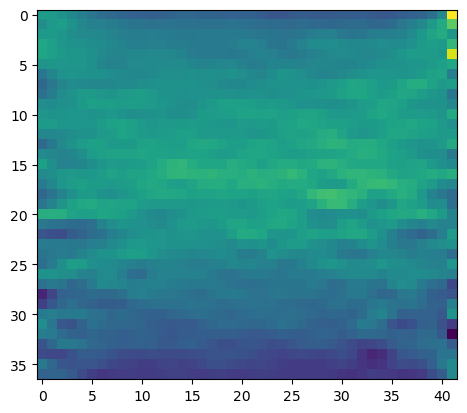

In [174]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [175]:
force_disp = pd.read_csv('manu/Stiff2_Homo_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [176]:
with open('manu/stiff2_homo.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)

### Stiff1_Hetero

In [136]:
out = []

for i in tqdm(range(1,190)):
    df = pd.read_csv('manu/Stiff1_Hetero_Final_42x41/Stiff1_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[:-1,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 189/189 [00:27<00:00,  6.84it/s]


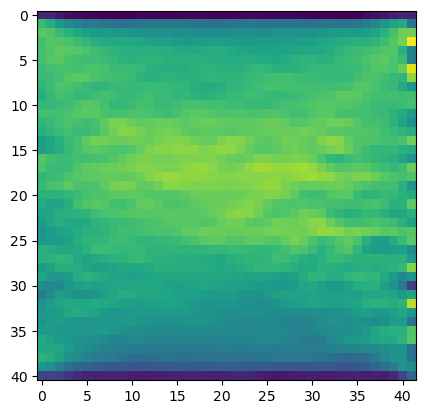

In [137]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

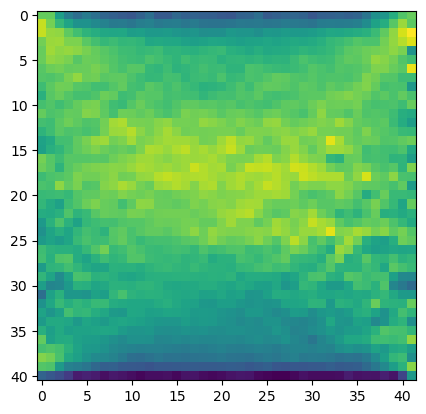

In [138]:
plt.imshow(df['Axial strain Eyy - GL [S]'].to_numpy().reshape([42,43])[:-1,:-1])

In [143]:
force_disp = pd.read_csv('manu/Stiff1_Hetero_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [144]:
with open('manu/stiff1_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)

### Stiff2_Hetero

In [147]:
out = []

for i in tqdm(range(1,158)):
    df = pd.read_csv('manu/Stiff2_Hetero_Final_42x41/Stiff2_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-1,:-2] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[2:-1,:-2]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty
y = y[2:-1,:-2]

100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


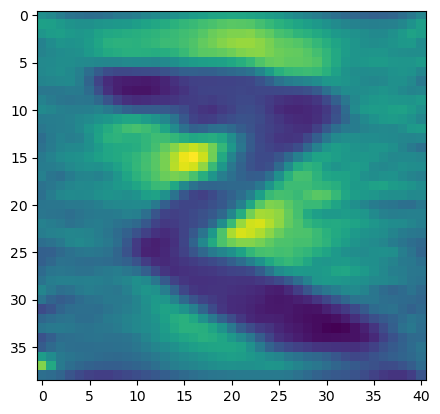

In [148]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [183]:
out = []

for i in tqdm(range(1,158)):
    df = pd.read_csv('manu/Stiff2_Hetero_Final_42x41/Stiff2_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-1,:-2] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[2:-1,:-2]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty
y = y[2:-1,:-2]

100%|██████████| 157/157 [00:24<00:00,  6.35it/s]


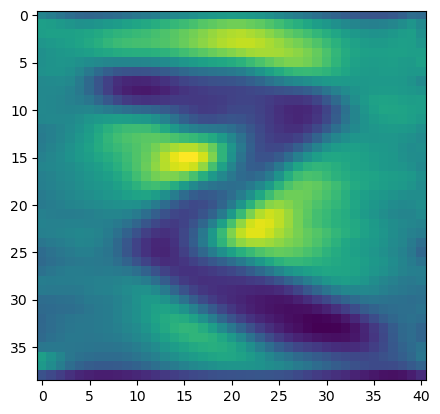

In [184]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [185]:
force_disp = pd.read_csv('manu/Stiff2_Hetero_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [186]:
with open('manu/stiff2_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)

### Stiff3_Hetero

In [160]:
out = []

for i in tqdm(range(1,158)):
    df = pd.read_csv('manu/Stiff3_Hetero_Final_42x41/Stiff3_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[:-1,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 157/157 [00:23<00:00,  6.73it/s]


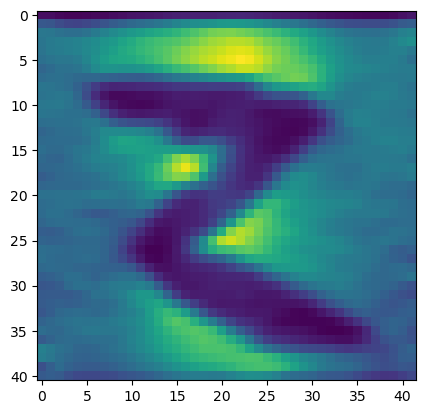

In [161]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [162]:
force_disp = pd.read_csv('manu/Stiff3_Hetero_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)
n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
force = np.interp(new_time_range, time, force)

In [163]:
with open('manu/stiff3_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist,force], f)